## Using ART to Defend against Poisoning Attacks using DP-InstaHide

DP-InstaHide is a training method developed by [Borgnia et. al. (2021)](https://arxiv.org/abs/2103.02079). This method provides a differential privacy guarantee and strong empirical performance against poisoning attacks. The training protocol uses:
* Data augmentation (such as Mixup)
* Additive noise (such as Laplacian noise)

Using this method, we show how ART can defend against poisoned samples.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warnings
warnings.filterwarnings('ignore')

# disable TensorFlow eager execution
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.preprocessor import Mixup
from art.defences.trainer import DPInstaHideTrainer
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist, preprocess

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

### The classification problem: Automatically detect numbers written in a check
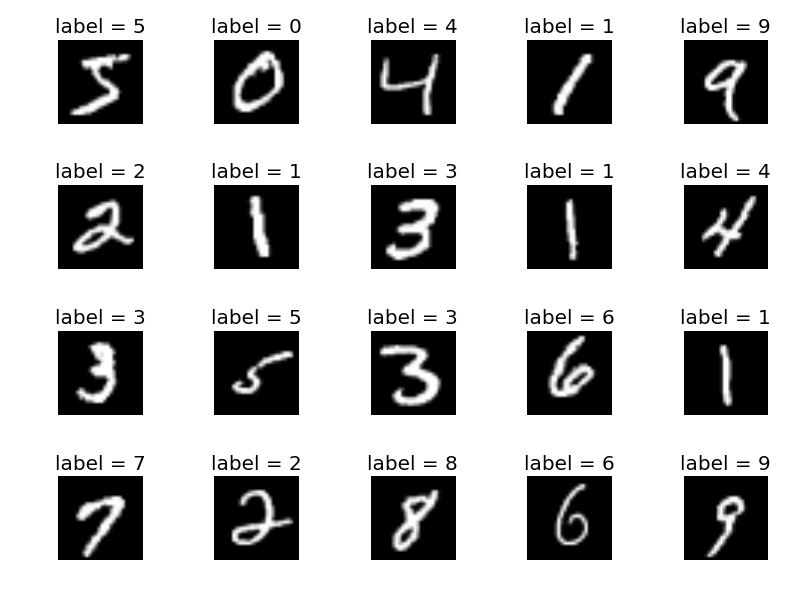

In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 
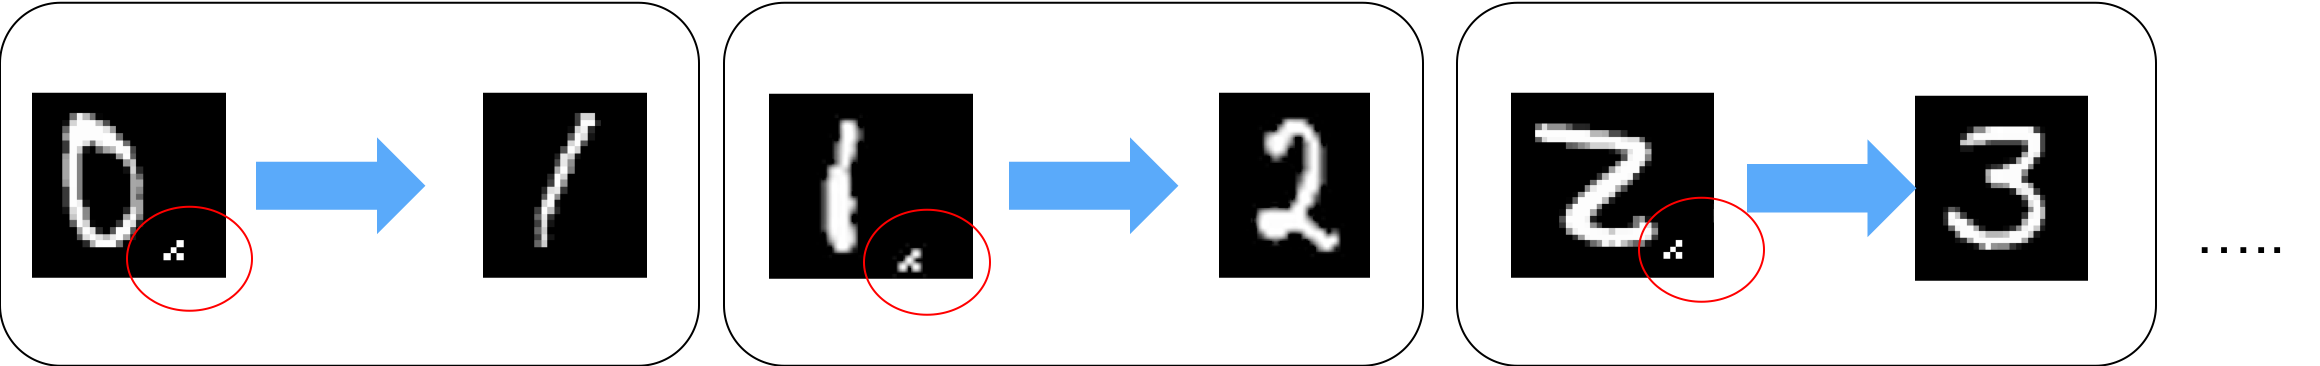

In [4]:
max_val = np.max(x_raw)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [5]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.arange(10) # 0, 1, 2, 3, ...
    targets = (np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [6]:
# Poison training data
percent_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

## Victim bank trains a neural network

In [7]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [8]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 11194 samples
Epoch 1/5


2022-12-09 13:29:00.378366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11194/11194 [==============================] - 7s 598us/sample - loss: 1.2673 - accuracy: 0.5414
Epoch 2/5
11194/11194 [==============================] - 6s 560us/sample - loss: 0.4681 - accuracy: 0.8573
Epoch 3/5
11194/11194 [==============================] - 7s 628us/sample - loss: 0.2771 - accuracy: 0.9166
Epoch 4/5
11194/11194 [==============================] - 8s 727us/sample - loss: 0.2024 - accuracy: 0.9413
Epoch 5/5
11194/11194 [==============================] - 7s 632us/sample - loss: 0.1566 - accuracy: 0.9506


## The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.32%


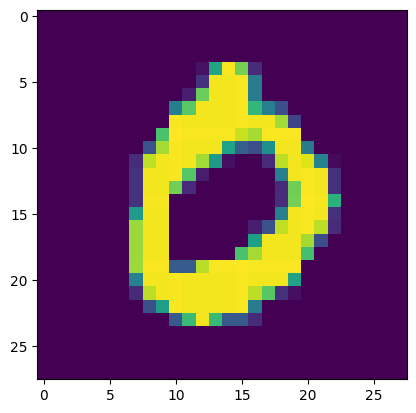

Prediction: 0


In [9]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

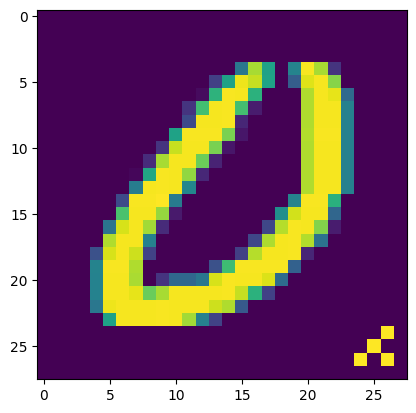

Prediction: 1

 Effectiveness of poison: 95.76%


In [10]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

### Evaluate accuracy on entire test set

In [11]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 96.80%


## Defend Against Poison using DP-InstaHide

### Re-Initialize the model

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(0, 1))

[INFO] Inferred 7 hidden layers on Keras classifier.


### Re-train the model using DP-InstaHide

We will be using 2-way Mixup for the augmentation and Laplacian noise with a scale of 0.3 for the additive noise.

In [13]:
mixup = Mixup(num_classes=10, num_mix=2)
trainer = DPInstaHideTrainer(
    classifier=classifier,
    augmentations=mixup,
    noise='laplacian',
    scale=0.3,
    clip_values=(0, 1)
)
trainer.fit(x_train, y_train, nb_epochs=5, batch_size=128)

[INFO] Performing adversarial training with DP-InstaHide protocol
[INFO] Adversarial Training DP-InstaHide


DP-InstaHide training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] epoch: 0 time(s): 18.6, loss: 0.0161, acc: 0.4298
[INFO] epoch: 1 time(s): 19.0, loss: 0.0132, acc: 0.5779
[INFO] epoch: 2 time(s): 20.8, loss: 0.0122, acc: 0.6118
[INFO] epoch: 3 time(s): 22.8, loss: 0.0116, acc: 0.6383
[INFO] epoch: 4 time(s): 24.3, loss: 0.0111, acc: 0.7056


### Re-evaluation on clean test samples


Clean test set accuracy: 94.08%


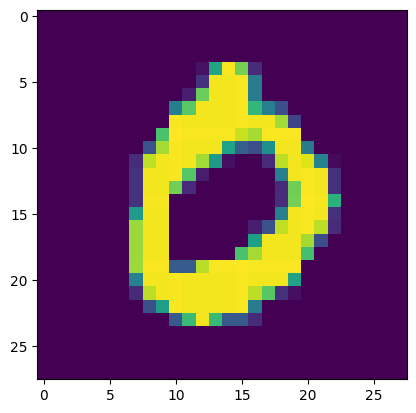

Prediction: 0


In [14]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### Re-evaluate on poisoned test samples

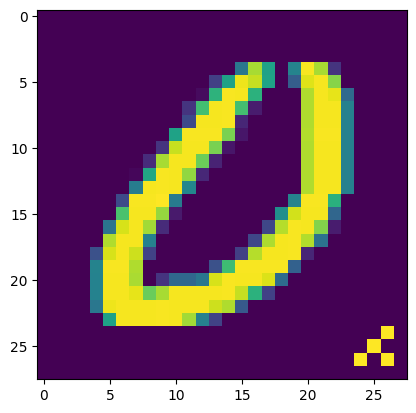

Prediction: 1

 Effectiveness of poison: 33.73%


In [15]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

### Re-evaluate accuracy on the entire test set

In [16]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 74.16%
